# <span style="color:#336699">Regressão com MLP</span>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Autor: Flávio Belizário da Silva Mota
    <br/><br/>
    Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contato: <a href="mailto:flavio.belizario.mota@gmail.com">flavio.belizario.mota@gmail.com</a>
    <br/><br/>
    Data de entrega: 16 de Julho de 2022
    <br>
    Professor: Marcos Goncalves Quiles
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Objetivo.</b> Esse caderno Jupyter tem como objetivo apresentar o uso do MLP na tarefa de regressão, como parte do Projeto 1 da disciplina de Neurocomputação (CAP-351). Os dados utilizados são referentes ao conjunto de análises de eficiência energética considerando 12 tipos de edifícios diferentes. Os edifícios diferem quanto à área envidraçada, distribuição da área envidraçada, orientação, entre outros parâmetros. O conjunto de dados é composto por 768 amostras e 8 atributos, com o objetivo de prever duas respostas de valor real.
</div>

<br/>
<div>
    <b>Os dados podem ser encontrados em:</b>
    <div style="margin-left: 10px; margin-right: 10px">
    https://archive.ics.uci.edu/ml/datasets/Energy+efficiency
    </div>
</div>

## Instalando e importando bibliotecas

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=386665734f258939b8d644f781a5044ffe014e3c04fd5840b8041aec4be44e31
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn import preprocessing
from numpy.random import seed
seed(42)

## Baixando e carregando os dados

Baixando os dados da UCI:

In [3]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
wget.download(url)

'ENB2012_data.xlsx'

Lendo o arquivo excel e criando o dataframe:

In [4]:
df = pd.read_excel("ENB2012_data.xlsx")

In [5]:
print("Nosso conjunto de dados tem %s linhas e %s colunas" % 
      (df.shape[0], df.shape[1]))

Nosso conjunto de dados tem 768 linhas e 10 colunas


Exibindo os atributos e seus tipos:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


## Separando o conjunto

Criando as variáveis x e y para armazenar os exemplos e as classes: 

In [7]:
x = df.drop(columns=['Y1', 'Y2'])
y = df['Y1'].values

Separando o conjunto em treino (80%) e teste (20%) e validação (20% do conjunto de treino):

In [8]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.2, shuffle = True, random_state = 42)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
    test_size=0.25, random_state= 42) # 0.25 x 0.8 = 0.2

# Padronizando os dados
scaler_x = preprocessing.MinMaxScaler().fit(x)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
x_test = scaler_x.transform(x_test)

print(len(x_train), "amostras de treinamento")
print(len(x_val), "amostras de validação")
print(len(x_test), "amostras de teste")

460 amostras de treinamento
154 amostras de validação
154 amostras de teste


## Funções para plotagem de gráficos

In [9]:
import matplotlib.pyplot as plt

def curvas_erro_acuracia(history):
  fig, ax = plt.subplots(1,2, figsize=(16,8))
  ax[0].plot(history.history['loss'], color='b', label="Treino")
  ax[0].plot(history.history['val_loss'], color='r', label="Validação")
  ax[0].set_xlabel('Épocas')
  ax[0].set_ylabel('Loss')
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['mean_absolute_error'], color='b', label="Treino")
  ax[1].plot(history.history['val_mean_absolute_error'], color='r',label="Validação")
  ax[1].set_xlabel('Épocas')
  ax[1].set_ylabel('MAE')
  legend = ax[1].legend(loc='best', shadow=True)

def n_ultimas_epocas(history, n):
  plt.xlabel("Épocas")
  plt.ylabel("Loss")
  plt.plot(history.history['loss'][-n:], label="Treino")
  plt.plot(history.history['val_loss'][-n:], label="Val")
  plt.legend()
  plt.show()

def real_previsto(x_test, y_test, model):
  y_res = model.predict(x_test)
  plt.scatter(y_test, y_res)
  plt.xlabel("Real")
  plt.ylabel("Previsto")
  plt.plot([0,50], [0,50])
  plt.show()

## Modelos

### Modelo 1

MLP com 1 camada oculta com 10 neurônios, 1 camada oculta com 20 neurônios e 1 neurônio na camada de saída.
<br>Função de ativação das camadas ocultas: sigmoid
<br>Função de ativação da camada de saída: linear
<br>Modelo treinado por 500 épocas utilizando o otimizador SGD com taxa de aprendizado de 0.1 e momentum de 0.5, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto:

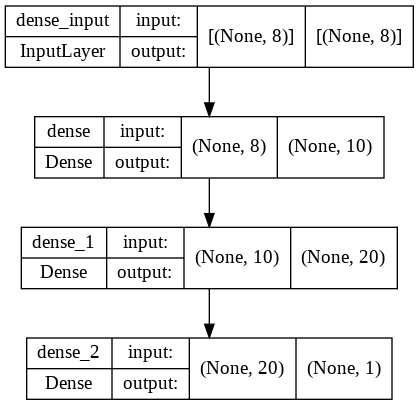

In [10]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units=10, input_shape=(8,), activation="sigmoid"))
model1.add(keras.layers.Dense(units=20, activation="sigmoid"))
model1.add(keras.layers.Dense(units=1, activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)

model1.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model1, show_shapes=True)

In [11]:
history1 = model1.fit(x_train, y_train, epochs=500, batch_size=100, 
                    validation_data=(x_val, y_val), 
                    verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 65ms/step - loss: 219.9342 - mean_absolute_error: 12.1111 - val_loss: 90.0361 - val_mean_absolute_error: 8.3056
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 56.8406 - mean_absolute_error: 6.3125 - val_loss: 21.3966 - val_mean_absolute_error: 3.2985
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 20.7500 - mean_absolute_error: 3.3774 - val_loss: 17.9443 - val_mean_absolute_error: 2.9942
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 15.0203 - mean_absolute_error: 2.8564 - val_loss: 12.1228 - val_mean_absolute_error: 2.6886
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 44.4465 - mean_absolute_error: 4.9515 - val_loss: 23.6415 - val_mean_absolute_error: 4.1606
Epoch 6/500
5/5 [==============================] - 0s 12ms/step - loss: 21.8585 - mean_absolute_error: 3.4981 - val_loss: 20.2618 - val_mean_absolute_error: 3.1679
Epoch 7/500
5/

Gráficos com loss e MAE ao longo das épocas:

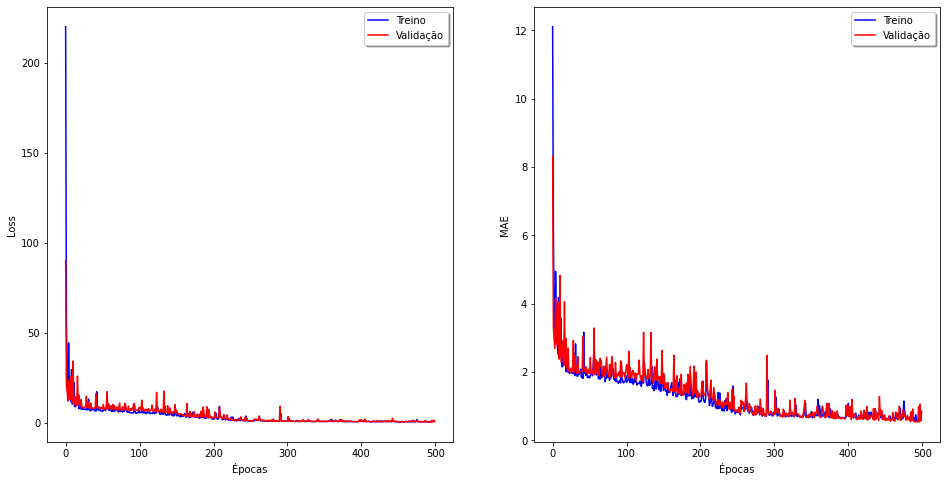

In [12]:
curvas_erro_acuracia(history1)

Loss nas últimas 50 épocas:

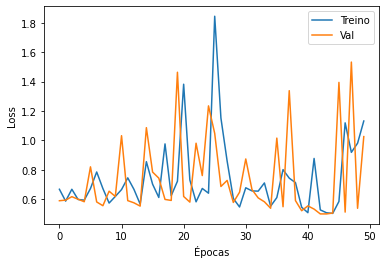

In [13]:
n_ultimas_epocas(history1, 50)

Testando o modelo com dados de teste:

In [14]:
score = model1.evaluate(x_test, y_test, verbose=0)
print("Teste loss:", score[0])
print("Teste MAE:", score[1])

Teste loss: 1.217230200767517
Teste MAE: 0.9038463234901428


Visualizando os dados reais e previstos:

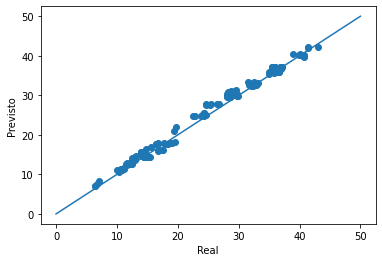

In [15]:
real_previsto(x_test,y_test,model1)

Utilizando essa configuração de rede é possível observar que, apesar do rápido decaimento da energia do erro, existem muitas flutuações nos valores ao longo das épocas, sendo que mesmo nas últimas épocas, essa variação ainda persiste. Isso demonstra que as 500 épocas não são suficientes para que a rede possa convergir para um valor de energia de erro constante. Entretanto, ao analisar a distribuição gerada entre os valores previstos e reais, o modelo consegue aproximar os valores. Através da análise do MAE do modelo no conjunto de teste, é possível notar que um valor 0.5 foi obtido o que indica que, para cada valor previsto existe uma variação em relação ao valor real de 0.5.  

### Modelo 2

MLP com 1 camada oculta com 10 neurônios, 1 camada oculta com 20 neurônios, 1 camada oculta com 10 neurônios e 1 neurônio na camada de saída.
<br>Função de ativação das camadas ocultas: sigmoid
<br>Função de ativação da camada de saída: linear
<br>Modelo treinado por 500 épocas utilizando o otimizador SGD com taxa de aprendizado de 0.1 e momentum de 0.5, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto:

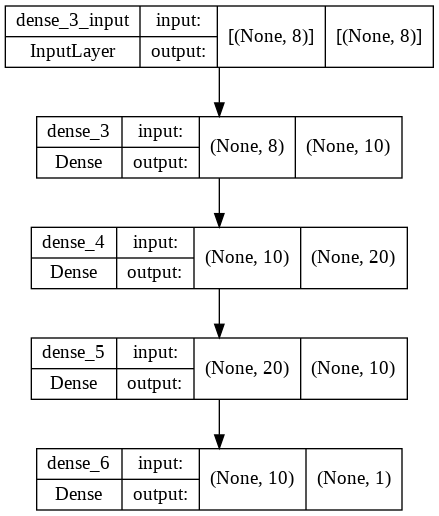

In [16]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=10, input_shape=(8,), activation="sigmoid"))
model2.add(keras.layers.Dense(units=20, activation="sigmoid"))
model2.add(keras.layers.Dense(units=10, activation="sigmoid"))
model2.add(keras.layers.Dense(units=1, activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)

model2.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model2, show_shapes=True)

In [17]:
history2 = model2.fit(x_train, y_train, epochs=500, batch_size=100, 
                    validation_data=(x_val, y_val), 
                    verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 52ms/step - loss: 239.8851 - mean_absolute_error: 12.5472 - val_loss: 119.8952 - val_mean_absolute_error: 9.5688
Epoch 2/500
5/5 [==============================] - 0s 10ms/step - loss: 100.8655 - mean_absolute_error: 8.9969 - val_loss: 109.7188 - val_mean_absolute_error: 9.5651
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 98.4948 - mean_absolute_error: 8.9704 - val_loss: 112.0478 - val_mean_absolute_error: 9.5647
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 98.7131 - mean_absolute_error: 8.9665 - val_loss: 122.6022 - val_mean_absolute_error: 9.5761
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 99.2790 - mean_absolute_error: 8.8279 - val_loss: 113.2582 - val_mean_absolute_error: 9.6343
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 100.6304 - mean_absolute_error: 9.0470 - val_loss: 109.6059 - val_mean_absolute_error: 9.5631
Epoch 

Gráficos com loss e MAE ao longo das épocas:

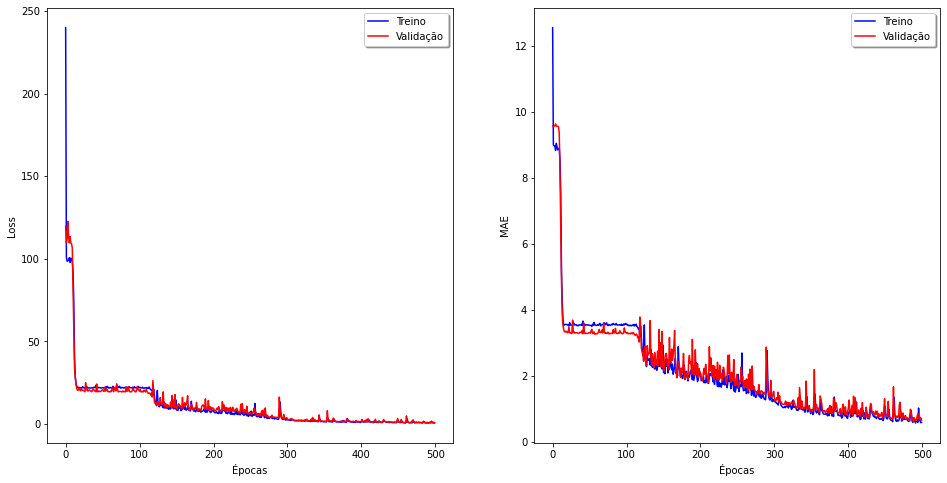

In [18]:
curvas_erro_acuracia(history2)

Loss nas últimas 50 épocas:

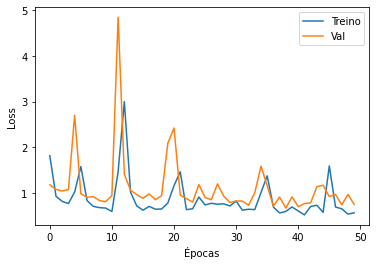

In [19]:
n_ultimas_epocas(history2, 50)

Testando o modelo com dados de teste:

In [20]:
score = model2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 0.6094611287117004
Test metric: 0.6045436263084412


Visualizando os dados reais e previstos:

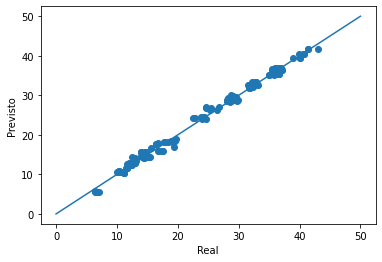

In [21]:
real_previsto(x_test, y_test, model2)

Adicionar mais uma camada oculta na rede implicou no aumento da energia do erro e do MAE em relação ao conjunto de testes, o que indica que para melhorar a performance do modelo, aumentar o número de camadas não seja exatamente a melhor solução.

### Modelo 3

MLP com 1 camada oculta com 10 neurônios, 1 camada oculta com 20 neurônios e 1 neurônio na camada de saída.
<br>Função de ativação das camadas ocultas: sigmoid
<br>Função de ativação da camada de saída: linear
<br>Modelo treinado por 500 épocas utilizando o otimizador SGD com taxa de aprendizado de 0.1 e momentum de 0.5, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto e adição de regularização em todas as camadas:

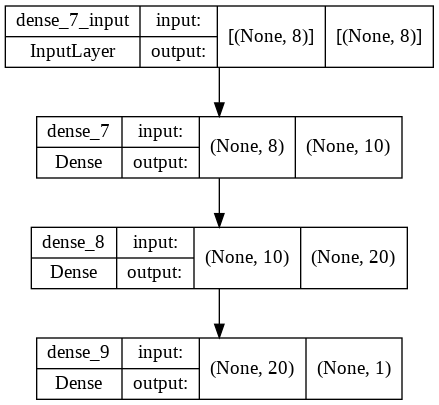

In [22]:
fl2 = 0.2

model3 = keras.Sequential()
model3.add(keras.layers.Dense(units=10, input_shape=(8,), kernel_regularizer=l2(fl2),
                             activation="sigmoid"))
model3.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
model3.add(keras.layers.Dense(units=1, kernel_regularizer=l2(fl2), activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.10, momentum=0.5)

model3.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model3, show_shapes=True)

In [23]:
history3 = model3.fit(x_train, y_train, epochs=500, batch_size=100, 
                    validation_data=(x_val, y_val), 
                    verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 44ms/step - loss: 241.0930 - mean_absolute_error: 11.8305 - val_loss: 415.5051 - val_mean_absolute_error: 16.2413
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 234.0046 - mean_absolute_error: 10.7295 - val_loss: 121.0093 - val_mean_absolute_error: 7.2955
Epoch 3/500
5/5 [==============================] - 0s 10ms/step - loss: 94.7609 - mean_absolute_error: 5.8617 - val_loss: 71.0816 - val_mean_absolute_error: 4.3889
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 63.6862 - mean_absolute_error: 4.0340 - val_loss: 60.1863 - val_mean_absolute_error: 3.7739
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 57.0398 - mean_absolute_error: 3.8083 - val_loss: 53.3357 - val_mean_absolute_error: 3.8021
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 55.6924 - mean_absolute_error: 4.0433 - val_loss: 51.0076 - val_mean_absolute_error: 3.4652
Epoch 7/500

Gráficos com loss e MAE ao longo das épocas:

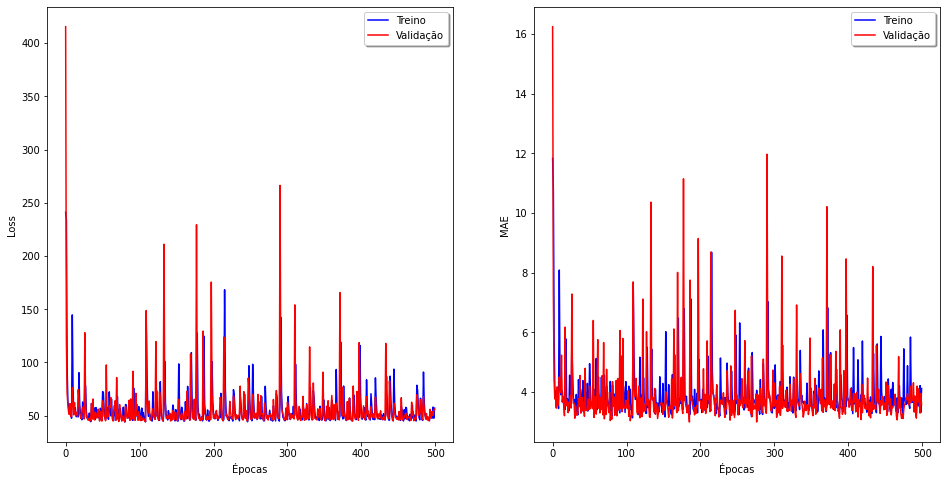

In [24]:
curvas_erro_acuracia(history3)

Loss nas últimas 50 épocas:

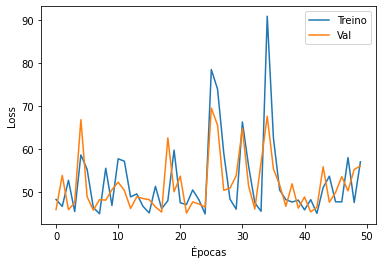

In [25]:
n_ultimas_epocas(history3,50)

Testando o modelo com dados de teste:

In [26]:
score = model3.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 56.02010726928711
Test metric: 3.7304704189300537


Visualizando os dados reais e previstos:



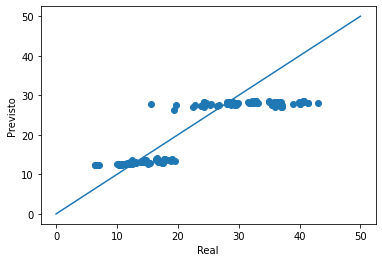

In [27]:
real_previsto(x_test, y_test, model3)

Ao adicionar regularização nas camadas da rede o modelo sequer converge para um valor de energia do erro durante as 500 épocas. Fica claro pelos gráficos apresentados e pelas métricas que o modelo não conseguiu extrair as relações dos dados da forma correta, imputando um erro médio em relação ao valor real de 3,44.

### Modelo 4

MLP com 1 camada oculta com 10 neurônios, 1 camada oculta com 20 neurônios e 1 neurônio na camada de saída.
<br>Função de ativação das camadas ocultas: relu
<br>Função de ativação da camada de saída: linear
<br>Modelo treinado por 500 épocas utilizando o otimizador SGD com taxa de aprendizado de 0.1 e momentum de 0.5, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto:

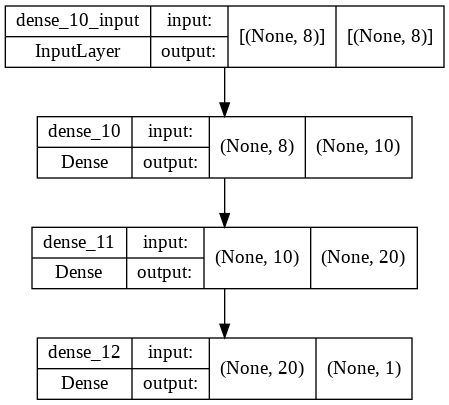

In [28]:
model4 = keras.Sequential()
model4.add(keras.layers.Dense(units=10, input_shape=(8,), activation="relu"))
model4.add(keras.layers.Dense(units=20, activation="relu"))
model4.add(keras.layers.Dense(units=1, activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)

model4.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model4, show_shapes=True)

In [29]:
history4 = model4.fit(x_train, y_train, epochs=500, batch_size=100, 
                    validation_data=(x_val, y_val), 
                    verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 49ms/step - loss: 5571.1455 - mean_absolute_error: 50.6293 - val_loss: 833528640.0000 - val_mean_absolute_error: 28545.3438
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 3605607590244909056.0000 - mean_absolute_error: 1328116864.0000 - val_loss: 467593295673950208.0000 - val_mean_absolute_error: 683807936.0000
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 154983327940476928.0000 - mean_absolute_error: 310143680.0000 - val_loss: 3369867847663616.0000 - val_mean_absolute_error: 58050560.0000
Epoch 4/500
5/5 [==============================] - 0s 19ms/step - loss: 2936753950294016.0000 - mean_absolute_error: 52531204.0000 - val_loss: 153664182288384.0000 - val_mean_absolute_error: 12396136.0000
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 43097014665216.0000 - mean_absolute_error: 5343430.0000 - val_loss: 13914012123136.0000 - val_mean_absolute_error: 3730149

Gráficos com loss e MAE ao longo das épocas:

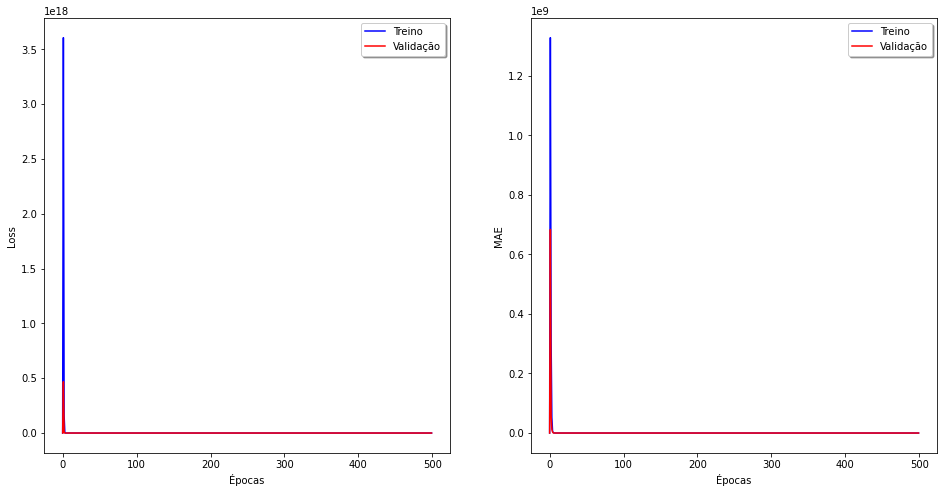

In [30]:
curvas_erro_acuracia(history4)

Loss nas últimas 50 épocas:

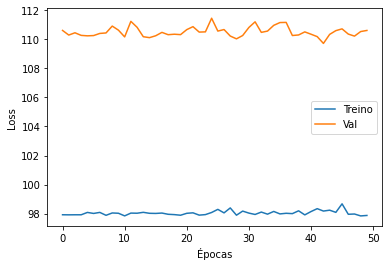

In [31]:
n_ultimas_epocas(history4, 50)

Testando o modelo com dados de teste:

In [32]:
score = model4.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 105.33818054199219
Test metric: 9.279706001281738


Visualizando os dados reais e previstos:

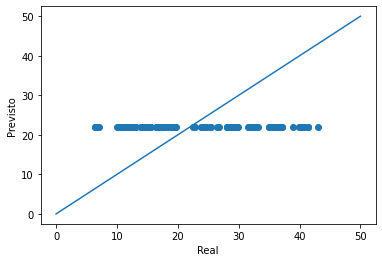

In [33]:
real_previsto(x_test, y_test, model4)

Alterar as funções de ativação da rede resultaram em um modelo que converge rapidamente para um valor de energia do erro que ainda é muito alto, gerando um modelo que não consegue estimar os valores esperados, como é possível observar no gráfico que apresenta a relação entre os valores do dado real e o valor previsto, bem como no valor de MAE do conjunto de teste (9,26).

### Modelo 5

MLP com 1 camada oculta com 10 neurônios, 1 camada oculta com 20 neurônios e 1 neurônio na camada de saída.
<br>Função de ativação das camadas ocultas: relu
<br>Função de ativação da camada de saída: linear
<br>Modelo treinado por 500 épocas utilizando o otimizador SGD com taxa de aprendizado de 0.1 e momentum de 0.9, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto:

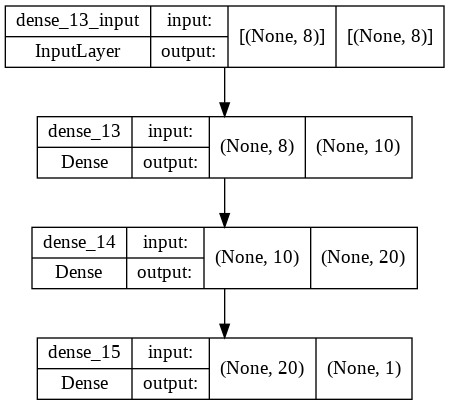

In [34]:
model5 = keras.Sequential()
model5.add(keras.layers.Dense(units=10, input_shape=(8,), activation="sigmoid"))
model5.add(keras.layers.Dense(units=20,  activation="sigmoid"))
model5.add(keras.layers.Dense(units=1, activation="linear"))

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model5.compile(loss='mean_squared_error', optimizer='sgd', metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model5, show_shapes=True)

In [35]:
history5 = model5.fit(x_train, y_train, epochs=500, batch_size=100, 
                    validation_data=(x_val, y_val), 
                    verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 39ms/step - loss: 382.7419 - mean_absolute_error: 16.4833 - val_loss: 194.2726 - val_mean_absolute_error: 10.3844
Epoch 2/500
5/5 [==============================] - 0s 8ms/step - loss: 123.7848 - mean_absolute_error: 8.7199 - val_loss: 106.0607 - val_mean_absolute_error: 9.1432
Epoch 3/500
5/5 [==============================] - 0s 9ms/step - loss: 89.5317 - mean_absolute_error: 8.3971 - val_loss: 97.8677 - val_mean_absolute_error: 8.9454
Epoch 4/500
5/5 [==============================] - 0s 8ms/step - loss: 86.3894 - mean_absolute_error: 8.3328 - val_loss: 94.8660 - val_mean_absolute_error: 8.7391
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 82.4108 - mean_absolute_error: 8.0775 - val_loss: 89.2837 - val_mean_absolute_error: 8.4798
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 78.4403 - mean_absolute_error: 7.8640 - val_loss: 84.7804 - val_mean_absolute_error: 8.1943
Epoch 7/500
5/5

Gráficos com loss e MAE ao longo das épocas:

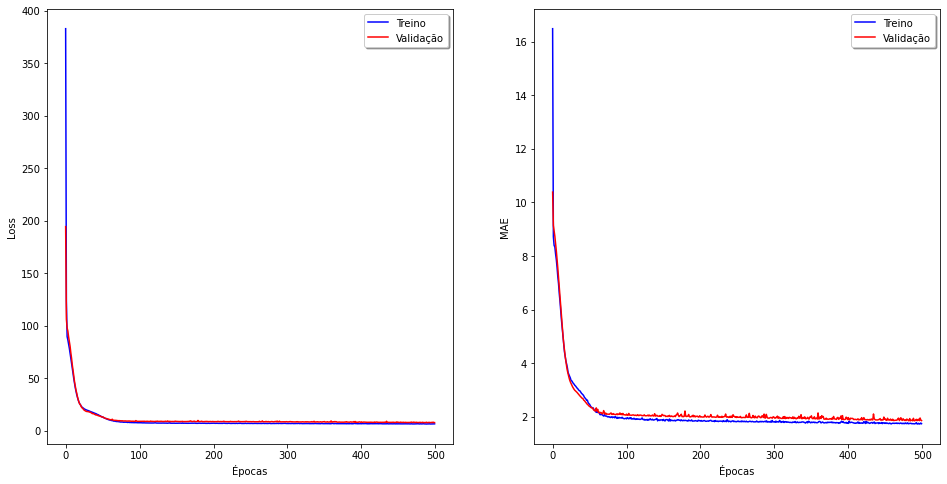

In [36]:
curvas_erro_acuracia(history5)

Loss nas últimas 50 épocas:

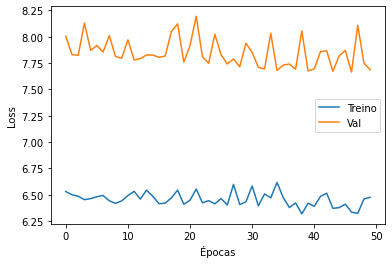

In [37]:
n_ultimas_epocas(history5, 50)

Testando o modelo com dados de teste:

In [38]:
score = model5.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 7.631392002105713
Test metric: 1.876065969467163


Visualizando os dados reais e previstos:

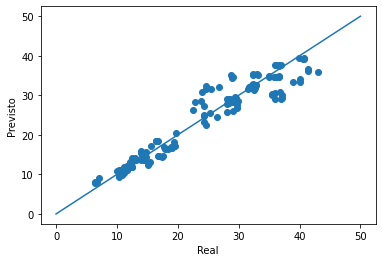

In [39]:
real_previsto(x_test, y_test, model5)

Variar o valor de momentum para o modelo gerou um modelo que conseguiu convergir rapidamente, mas que ainda assim apresenta um valor de energia do erro alto se comparado ao modelo 1. Dessa forma, o modelo acaba errando o valor, em média, 1,94 em relação ao valor real, como pode ser observado no resultado obtido com os dados de teste. 

## Considerações Finais

O intuito desse notebook jupyter foi apresentar o emprego de diferentes topologias de redes MLP para a tarefa de regressão. Dado o conjunto de dados apresentado, o modelo que melhor performou a tarefa foi o modelo 1, uma rede MLP com 1 camada oculta de 10 neurônios, 1 camada oculta de 20 neurônios e 1 neurônio na camada de saída, empregando a função de ativação sigmoid em todas as camadas ocultas e função de ativação linear na camada de saída. Esse modelo foi treinado por 500 épocas utilizando o otimizador SGD com uma taxa de aprendizado de 0.1 e momentum de 0.5, loss como erro médio quadrático e como métrica de acerto o erro médio absoluto. Nessa configuração, foi obtido um valor de 0.51 para a energia do erro e de 0.51 para o MAE com o conjunto de teste. Variações de topologia da rede resultaram em valores mais altos de erro (loss e MAE), sendo a rede com a adição da regularização aquela com os maiores valores. Para aprofundar o estudo desse problema, diferentes hyperparâmetros poderiam passar por um processo de otimização, como aumento da quantidade de épocas,variação do valor da taxa de aprendizagem e momentum e outros valores de regularização.